----------------------------
Input Parameter:
Ny : 51
Ra : 1720
Pr : 1.0
alpha : 3.14
plot : True
----------------------------
   3 largest eigenvalues:
   3: 8.9399e-13 -5.6548e+01j
   2: 1.7175e-12 -4.2652e+01j
   1: 2.5763e-12 9.1858e-02j
Time used:     0.95 s.


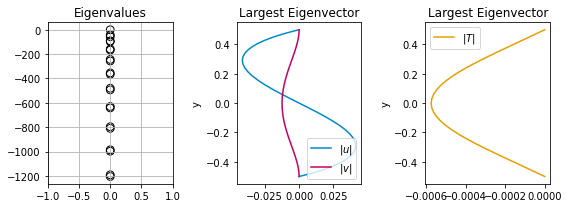

In [1]:
import numpy as np 
from pypde import *
from scipy.linalg import eig
import matplotlib.pyplot as plt
from pypde.stability.rbc1d import solve_rbc1d
# Parameters
Ny    = 51
alpha = 3.14
Ra    = 1720
Pr    = 1.0

# Find the growth rates for given Ra
evals,evecs = solve_rbc1d(Ny=Ny,Ra=Ra,Pr=Pr,alpha=alpha,plot=True)


## 1D Convolution

In [260]:
def nu(Ra,Pr):
    return np.sqrt(Pr/Ra)

def kappa(Ra,Pr):
    return  np.sqrt(1/Pr/Ra)


def convolution_matrix(ahat):
    '''
    Physical Space 
        C = A @ B
    Spectral Space
        C = Conv(A,B) = M @ B
        
    Returns Convolution matrix M, that can be 
    multiplied with B to obtain Conv(A,B)
    
    Literature
    [1] The Special Functions And Their Approximations -
    Y.L. Luke, section 8.6.1, eq. (24)
    
    Here, formula (25) of ref. [1] is used

    >>>
    shape = (10,)
    B = Field([Base(shape[0],"CH")] )
    a = np.sin(B.x)+1
    b = np.cos(B.x)+1
    c = a*b
    ahat = B.forward(a)
    bhat = B.forward(b)
    chat = B.forward(c)
    
    np.allclose(chat, convolution_matrix(ahat)@bhat,1e-2)
    >>>
    '''
    N = ahat.size
    M = np.zeros((2*N,2*N))
    
    for i in np.arange(N):
        M[i,0] = 1.*ahat[i]
    
    for i in np.arange(1,N):
        M[0,i] = 0.5*M[i,0]
        M[i,i] = M[0,0] + .5*M[2*i,0]
        for j in np.arange(i+1,N):
            M[i,j] = .5*(M[i+j,0] + M[j-i,0])
            M[j,i] = M[i,j]
            
    return M[:N,:N]


def convolution_matrix(ahat):
    '''
    Physical Space 
        C = A @ B
    Spectral Space
        C = Conv(A,B) = M @ B
        
    Returns Convolution matrix M, that can be 
    multiplied with B to obtain Conv(A,B)
    
    Literature
    [1] The Special Functions And Their Approximations -
    Y.L. Luke, section 8.6.1, eq. (24)
    [2] Subroutines for Convolution Sums of Chebyshev
    and Fourier Series - G. Delic and S.M. Malherbe 
    
    Here, formula (24) of ref. [1] is used

    >>>
    shape = (10,)
    B = Field([Base(shape[0],"CH")] )
    a = np.sin(B.x)+1
    b = np.cos(B.x)+1
    c = a*b
    ahat = B.forward(a)
    bhat = B.forward(b)
    chat = B.forward(c)
    
    np.allclose(chat, convolution_matrix(ahat)@bhat,1e-2)
    >>>
    '''
    N = ahat.size
    ahat_padded = np.zeros(2*N)
    ahat_padded[:N] = ahat
    M = np.zeros((N,N))
    eps = np.ones(2*N); eps[1:] *= 2.
    
    # k = 0
    M[0,0] = 1.*ahat[0]
    for j in np.arange(1,N):
        M[0,j] = 0.5*ahat[j]
    # k > 0    
    for k in range(1,N):
        M[k,0] = 1.*ahat_padded[k]
        for j in np.arange(1,N):
            j1,j2 = int(k+j), int(np.abs(k-j))
            M[k,j] = (ahat_padded[j2]/eps[j2] + .5*ahat_padded[j1])
    return M

shape = (5,)
B = Field([Base(shape[0],"CH")] )
a = np.sin(B.x)+1
b = np.cos(B.x)+1
c = a*b
ahat = B.forward(a)
bhat = B.forward(b)
chat = B.forward(c)

convolution_matrix(ahat)#@bhat

array([[ 1.        ,  0.44004909,  0.        , -0.0193136 ,  0.        ],
       [ 0.88009818,  1.        ,  0.42073549,  0.        , -0.0193136 ],
       [ 0.        ,  0.42073549,  1.        ,  0.44004909,  0.        ],
       [-0.03862719,  0.        ,  0.44004909,  1.        ,  0.44004909],
       [ 0.        , -0.0193136 ,  0.        ,  0.44004909,  1.        ]])

In [2]:
Ra = 1720
Pr = 1
N = 51
shape = (N,)
alpha = 3.14#/2.

Lz = 2.

#Ra /= (2**3

# Normalization 1 (Diffusion)
nu = Pr
ka = 1
beta = Pr*Ra

# Normalization 2 (Turnover)
#nu = np.sqrt(Pr/Ra)
#ka = np.sqrt(1/Pr/Ra)    
#beta = 1.0

U = Field( [Base(shape[0],"CD")] )
V = Field( [Base(shape[0],"CD")] )
T = Field( [Base(shape[0],"CD")] )
P = Field( [Base(shape[0],"CN")] )
CH = Field([Base(shape[0],"CH",dealias=2)] )
z = U.x/Lz

# -- Matrices 
ICH = np.eye(CH.vhat.shape[0])
I = np.eye(U.vhat.shape[0])

Dz = CH.xs[0].dms(1)*(Lz)
Dx = 1.j*alpha*ICH
Dz2 = Dz@Dz
Dx2 = Dx@Dx


# -- Mean Field
UU = np.zeros(CH.shape)
VV = np.zeros(CH.shape)
TT = np.zeros(CH.shape)

TT[:] = CH.forward(-1.0*z) 
UU[:] = CH.forward(-1.0*z)

# -- Build

# -- Diffusion
D2U = nu*U.xs[0].ST@(-Dx2 - Dz2)@U.xs[0].S
D2V = nu*V.xs[0].ST@(-Dx2 - Dz2)@V.xs[0].S
D2T = ka*T.xs[0].ST@(-Dx2 - Dz2)@T.xs[0].S

# -- Buoyancy Uz
BVT = V.xs[0].ST@T.xs[0].S

# -- Pressure
DXP = U.xs[0].ST@Dx@P.xs[0].S
DZP = V.xs[0].ST@Dz@P.xs[0].S

# -- Divergence
DXU = P.xs[0].ST@Dx@U.xs[0].S
DZV = P.xs[0].ST@Dz@V.xs[0].S

# -- Non-Linear udU

# dTdz
dTdz = -1.0*ICH#np.diag(Dz@TB.vhat)
dTdz = convolution_matrix1d(Dz@TT,field=CH)
NTV = T.xs[0].ST@dTdz@V.xs[0].S

# dUdz
dUdz = convolution_matrix1d(Dz@UU,field=CH)
NUV  = U.xs[0].ST@dUdz@V.xs[0].S

# -- Non-Linear Udu
UU = convolution_matrix1d(UU,field=CH)
nUU = U.xs[0].ST@(UU@Dx)@U.xs[0].S
nUV = V.xs[0].ST@(UU@Dx)@V.xs[0].S

# -- Mass Matrices
MU = U.xs[0].ST@U.xs[0].S
MV = V.xs[0].ST@V.xs[0].S
MP = P.xs[0].ST@P.xs[0].S
MT = T.xs[0].ST@T.xs[0].S

# ------------
# LHS
L11 = 1.*D2U+1.*nUU  ; L12 = 1.*NUV         ; L13 = 1.*DXP   ; L14 = 0*I
L21 = 0.*I           ; L22 = 1.*D2V+1.*nUV  ; L23 = 1.*DZP   ; L24 =-1.*beta*BVT
L31 = 1.*DXU         ; L32 = 1.*DZV         ; L33 = 0.*I     ; L34 = 0.*I
L41 = 0.*I           ; L42 = 1.*NTV         ; L43 = 0.*I     ; L44 = 1.*D2T

# RHS
M11 = 1*MU    ; M12 = 0*I     ; M13 = 0*I      ; M14 = 0*I
M21 = 0*I     ; M22 = 1*MV    ; M23 = 0*I      ; M24 = 0*I
M31 = 0*I     ; M32 = 0*I     ; M33 = 0*I      ; M34 = 0*I
M41 = 0*I     ; M42 = 0*I     ; M43 = 0*I      ; M44 = 1*MT

L1 = np.block([ [L11,L12,L13,L14] ]);  M1 = np.block([ [M11,M12,M13,M14] ]) #u
L2 = np.block([ [L21,L22,L23,L24] ]);  M2 = np.block([ [M21,M22,M23,M24] ]) #v
L3 = np.block([ [L31,L32,L33,L34] ]);  M3 = np.block([ [M31,M32,M33,M34] ]) #p
L4 = np.block([ [L41,L42,L43,L44] ]);  M4 = np.block([ [M41,M42,M43,M44] ]) #T
    
# -- Solve EVP ----
L = np.block([ [L1], [L2], [L3], [L4]])
M = np.block([ [M1], [M2], [M3], [M4]])
evals,evecs = eig(L,1.j*M)

# Post Process egenvalues
evals, evecs = remove_evals(evals,evecs,higher=1400)
evals, evecs = sort_evals(evals,evecs,which="I")

print_evals(evals,n=5)

   5 largest eigenvalues:
   5: 8.9166e-13 -9.7255e+01j
   4: -9.2462e-14 -9.1348e+01j
   3: 8.9399e-13 -5.6548e+01j
   2: 1.7175e-12 -4.2652e+01j
   1: 2.5763e-12 9.1858e-02j


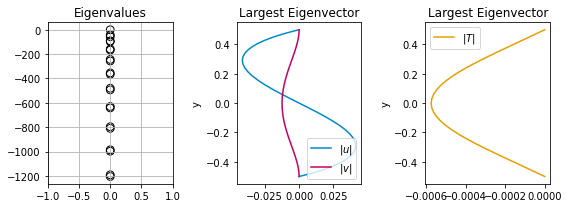

In [3]:
def split_evec(evecs,m=-1,N=None):
    if N is None:
        N = evecs.shape[0]//4
    u = evecs[0*N:1*N,m]
    v = evecs[1*N:2*N,m]
    p = evecs[2*N:3*N,m]
    t = evecs[3*N:4*N,m]
    return u,v,p,t

# -- Plot
blue = (0/255, 137/255, 204/255)
red  = (196/255, 0, 96/255)
yel   = (230/255,159/255,0)

u,v,p,t = split_evec(evecs,m=-1)
U.vhat[:] = np.real(u)
V.vhat[:] = np.real(v)
P.vhat[:] = np.real(p)
T.vhat[:] = np.real(t)
U.backward()
V.backward()
P.backward()
T.backward()

fig,(ax0,ax1,ax2) = plt.subplots(ncols=3, figsize=(8,3))
ax0.set_title("Eigenvalues")
ax0.set_xlim(-1,1);  ax0.grid(True)
ax0.scatter(np.real(evals[:]),np.imag(evals[:]), marker="o", edgecolors="k", s=60, facecolors='none'); 

ax1.set_ylabel("y"); ax1.set_title("Largest Eigenvector")
ax1.plot(U.v,z,  marker="", color=blue, label=r"$|u|$")
ax1.plot(V.v,z,  marker="", color=red,  label=r"$|v|$")
#ax2.plot(P.v,z,  marker="", color="k" , label=r"$|p|$")
ax1.legend(loc="lower right")
ax2.set_ylabel("y"); ax2.set_title("Largest Eigenvector")
ax2.plot(T.v,z,  marker="", color=yel , label=r"$|T|$")
ax2.legend()
plt.tight_layout(); 